Academic collaboration network
==============
***A Social Network Analysis*** 

**Student:** Lorenzo Betti 

**Course:** Social Networks 1 - 2022/2023

### Motivations

Academic publications can be studied through the lens of social network analysis. Indeed, the scientific literature can be modeled as a bipartite network, in which a set of nodes correspond to authors (i.e., researchers) and the other set of nodes to pubblications (i.e., papers). The collaboration network between authors can thus be obtained by projecting this bipartite network onto the set of authors. Here, two authors are connected if they have co-authored at least one paper together. At this point, tools of social network analysis can be used to better understand the factors that contribute to successful science, the relational structure between scientists, institutions, and ideas, and inequalities in academia [5].

This framework can complement results from related fields such as scientometric and sociology of science by, for instance, finding relationships between the network structure of the collaboration network and measures of performance [5]. It has been shown that network centrality measures such as degree (i.e., number of collaborators) and constraint are correlated with the performance of researchers, evaluated through theirr H-index [1]. In addition, both male and female successful researchers show the same collaboration pattern, namely the tendency to collaborate with more colleagues and act as brokers. However, female authors struggle in covering these positions in the collaboration network [3]. 


### Analysis

In this project, I will focus on studying the structure of the collaboration network of researchers, and how structural properties are related to researchers' performance. Here, network nodes represent individuals, ties are proxies for interactions, and the underlaying interaction mechanism is trasmission of knowledge. The questions I will focus on are:

**Q1**: Does the Granovetter’s Strength of Weak Ties hypothesis holds in academic collaboration networks?

**Q2**: How do centrality measures are different for male and female authors? 

**Q3**: Is the network assortative with respect to authors’ gender?

### Data

The dataset consists of the pubblications published on 16 peer reviewed journal belonging to the group ''Informs'', available from [6]. It is composed of 23.875 publications and the 22.911 authors of these publications. Authors' gender was obtained through a combination of authomatic methods (Genderize.io) and manual annotation, which resulted in 71% male, 13% female, and 16% unknown-gender authors.

### References

[1] Abbasi, Alireza, and Jorn Altmann. "On the correlation between research performance and social network analysis measures applied to research collaboration networks." 2011 44th Hawaii international conference on system sciences. IEEE, 2011. 

[2] Bozeman, Barry, and Monica Gaughan. "How do men and women differ in research collaborations? An analysis of the collaborative motives and strategies of academic researchers." Research policy 40.10 (2011): 1393-1402.

[3] Jadidi, Mohsen, et al. "Gender disparities in science? Dropout, productivity, collaborations and success of male and female computer scientists." Advances in Complex Systems 21.03n04 (2018): 1750011.

[4] Pan, Raj Kumar, and Jari Saramäki. "The strength of strong ties in scientific collaboration networks." EPL (Europhysics Letters) 97.1 (2012): 18007.

[5] Fortunato, Santo, et al. “Science of Science.” Science, vol. 359, no. 6379, Mar. 2018. Crossref, https://doi.org/10.1126/science.aao0185.

[6] Bravo-Hermsdorff, Gecia, et al. "Gender and collaboration patterns in a temporal scientific authorship network." Applied Network Science 4.1 (2019): 1-17.




In [1]:
%pylab inline
import os
import pandas as pd
import networkx as nx
import powerlaw
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tqdm.notebook import tqdm
RNG = np.random.RandomState(42)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

### Load data

Dataset downloaded from the official repository of the paper [6]: https://github.com/Gecia/INFORMS_TemporalGenderedAuthorshipNetwork

In [3]:
data_path = "../data/collab_network_bravo/"

# load authors, contains also the gender of each author estimated with genderize.io + manual refinement
authors = pd.read_csv(os.path.join(data_path, 'AuthorNodes.csv'), 
                      usecols=['Author_Node_ID', 'Gender_Label_Refined'])\
                        .rename(columns={'Author_Node_ID':'author_id',
                                         'Gender_Label_Refined':'gender'}).astype(str)

# load publications, contains the year of publications
publications = pd.read_csv(os.path.join(data_path, 'PublicationNodes.csv'),
                           converters={'Publication_Node_ID':str, 'Year':int})\
                            .rename(columns={'Publication_Node_ID':'publication_id', 'Year':'year'})


# load edges between authors and publications, contains the position of the author in the paper
edges = pd.read_csv(os.path.join(data_path, 'Edges.csv'), 
                    converters={'Publication_Node_ID':str, 'Author_Node_ID':str})\
                    .rename(columns={'Publication_Node_ID':'publication_id', 'Author_Node_ID':'author_id', 
                                     'Author_Position':'position'})

print("Number of authors: ", authors.shape[0])
print("Number of publications: ", publications.shape[0])
print("Number of edges: ", edges.shape[0])

Number of authors:  22911
Number of publications:  23875
Number of edges:  50527


In [4]:
# consider data only from the biggest CC
G = nx.from_pandas_edgelist(edges, source='author_id', target='publication_id')
G = G.subgraph(max(nx.connected_components(G), key=len))

# count how many publications and authors we have removed
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()
n_authors_ = len(set(G.nodes()).intersection(authors.author_id))
n_publications_ = n_nodes - n_authors_

# print new number basic statistic
# between parentheses, fraction wrt the instances in the original datase
print(f"Number of nodes: {n_nodes} ({round(n_nodes/(authors.shape[0] + publications.shape[0]) * 100, 2)}%)")
print(f"Number of edges: {n_edges} ({round(n_edges/edges.shape[0] * 100, 2)}%)")
print(f"Number of authors: {n_authors_} ({round(n_authors_/authors.shape[0] * 100, 2)}%)")
print(f"Number of publications: {n_publications_} ({round(n_publications_/publications.shape[0] * 100, 2)}%)")

# filter accordingly the dataframes
authors = authors[authors.author_id.isin(G.nodes())].reset_index(drop=True)
publications = publications[publications.publication_id.isin(G.nodes())].reset_index(drop=True)
edges = edges[(edges.author_id.isin(authors.author_id))].reset_index(drop=True)

Number of nodes: 30124 (64.39%)
Number of edges: 38169 (75.54%)
Number of authors: 13520 (59.01%)
Number of publications: 16604 (69.55%)


In [5]:
# get projections into authors and set node labels (gender)
G_authors = nx.bipartite.project(G, authors.author_id)
nx.set_node_attributes(G_authors, authors.set_index('author_id').to_dict()['gender'], name='gender')

G_authors.number_of_edges()

29450

### Basic statistic of the network

Some properties of the network that might be of interest:

- distribution of number of authors of publications (blue line),
- distribution of number of publications per author (orange line),
- distribution of number of collaborators per author (green line).

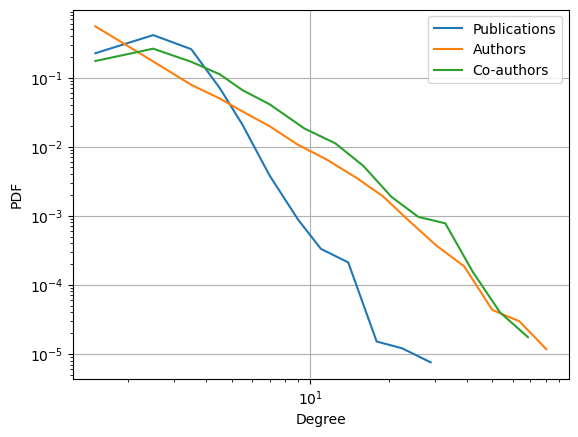

In [6]:
# number of authors per publication
powerlaw.plot_pdf([deg for _, deg in G.degree(publications.publication_id)], label='Publications')
powerlaw.plot_pdf([deg for _, deg in G.degree(authors.author_id)], label='Authors')
powerlaw.plot_pdf([deg for _, deg in G_authors.degree()], label='Co-authors')

plt.xlabel("Degree")
plt.ylabel("PDF")
plt.grid()
plt.legend();

Some observations:

- There are papers with more than 20 authors, but most of them have 2-4 authors (blue line),
- Authors have at most ~80 publications (orange line) and work with at most ~70 collaborators (green line).


### **Q1**: Does the Granovetter’s Strength of Weak Ties hypothesis holds in academic collaboration networks?

The question can be reformulated in quantitative terms as: are tie strengths correlated with the fraction of shared neighbors (link overlap) in the co-authorship network? If the correlation is positive, the Granovetter's hypothesis holds.

Two measures of tie strength are considered. Given a link between author _i_ and _j_:
1. The number of papers co-authored by _i_ and _j_,
2. The Newman's definition of tie strength<sup>[a]</sup>, used also in [4], which takes into account the number of authors of each paper co-authored by _i_ and _j_. Formally: 

    $w_{i, j}^{Newman} = \sum_p 1 / \left( n_p - 1 \right)$

    where $p$ is the set of paper co-authored by _i_ and _j_ and $n_p$ is the number of authors of paper $p$. The rationale is that the higher the number of authors of a paper, the smaller the contribution of that paper to the strength of the tie between any pair of co-authors of that paper. This assumes that authors split their time equally between the other authors. For large collaborations involving many authors, the tie strength is very small since is it likely that all authors do not know each other (there are few in our dataset).
    
The link overlap measure is defined as:
$$ O_{i, j} = \frac{n_{i,j}}{\left(k_i - 1 + k_j - 1 - n_{i,j}\right)}$$
where $n_{i,j}$ is the number of common neighbors of _i_ and _j_, $k_i$ and $k_j$ their degrees.
    
[a] Newman, Mark EJ. "Scientific collaboration networks. II. Shortest paths, weighted networks, and centrality." Physical review E 64.1 (2001): 016132.


In [7]:
def compute_tie_strengths_and_overlap(G, i, j):
    """ Compute the Newman's tie strength and number of common neighbors. 
    The input graph G is the bipartite graph.
    i and j are authors.
    """
    
    comm_neigs = list(nx.common_neighbors(G, i, j))
    tie_strength_newman = sum([(G.degree(common_paper) - 1) ** (-1) for common_paper in comm_neigs]) 
    
    return tie_strength_newman, len(comm_neigs)


def link_overlap(G, i, j):
    """ Compute the fraction of common neighbors between the extremes of a link.
    """
    n_common_neigs = len(list(nx.common_neighbors(G, i, j)))
    return n_common_neigs / (G.degree(i) - 1 + G.degree(j) - 1 - n_common_neigs)

In [8]:
# compute tie strengths and link overlap
# [link_overlap (in co-authorship net), tie_strength_newman, tie_strength (n. papers co-autored)]
weak_ties_data = [(link_overlap(G_authors, i, j), *compute_tie_strengths_and_overlap(G, i, j), 
                   i, j) 
                  for i, j in G_authors.edges()]
weak_ties_data = pd.DataFrame(weak_ties_data, columns=['overlap', 'strength_newman', 'strength', 
                                                       'i', 'j'])

# compute correlations
rho_overl_stren_newman, p_rho_overl_stren_newman = stats.spearmanr(weak_ties_data.overlap, 
                                                                   weak_ties_data.strength_newman)
rho_overl_stren, p_rho_overl_stren = stats.spearmanr(weak_ties_data.overlap, 
                                                     weak_ties_data.strength)

print("Correlation between tie overlap and strength:")
p_rho_overl_stren = f"p = {round(p_rho_overl_stren, 4)}" \
                            if p_rho_overl_stren > 0.0001 else "p < 0.0001"
print(f"Spearman's 𝜌 = {round(rho_overl_stren, 4)} ({p_rho_overl_stren})\n")

print("Correlation between tie overlap and Newman's strength:")
p_rho_overl_stren_newman = f"p = {round(p_rho_overl_stren_newman, 4)}" \
                            if p_rho_overl_stren_newman > 0.0001 else "p < 0.0001" 
print(f"Spearman's 𝜌 = {round(rho_overl_stren_newman, 4)} ({p_rho_overl_stren_newman})")



Correlation between tie overlap and strength:
Spearman's 𝜌 = -0.1132 (p < 0.0001)

Correlation between tie overlap and Newman's strength:
Spearman's 𝜌 = -0.6884 (p < 0.0001)


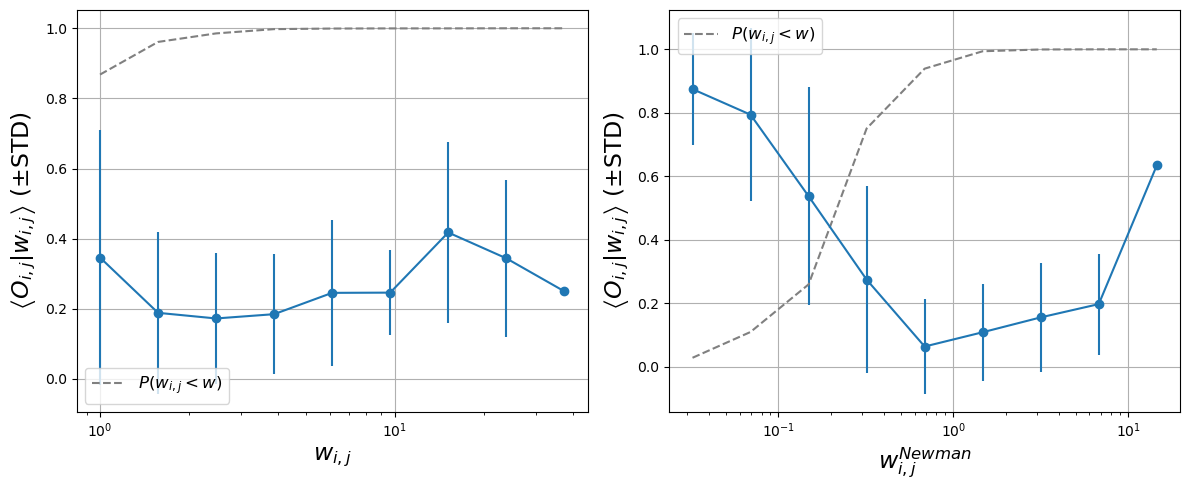

In [9]:
# plot tie strength (x-axis) Vs. overlap (y-axis)
# tie strength is (log) binned and for each bin we take the average of link overlap of all the edges within that bin
# added also cumulative probability distribution of data (grey dashed line)
plt.figure(figsize=(12,5))

for n_plot, strength_type in enumerate(['strength', 'strength_newman'], 1):
    
    plt.subplot(1, 2, n_plot)
    xbins = np.logspace(np.log10(weak_ties_data[strength_type].min()), 
                        np.log10(weak_ties_data[strength_type].max()), 
                        base=10, num=10)

    #plt.plot(xbins[:-1], [weak_ties_data[np.logical_and(xl <= weak_ties_data[:,1],  weak_ties_data[:,1] < xu)][:, 0].mean() 
    #                      for xl, xu in zip(xbins[:-1], xbins[1:])], 'o-', 
    #             )

    # for each bin of tie strength, compute mean and std of link overlap and plot it
    ys = [weak_ties_data[(xl <= weak_ties_data[strength_type])&(weak_ties_data[strength_type] < xu)].overlap
          for xl, xu in zip(xbins[:-1], xbins[1:])]
    ys = np.array([(y_.mean(), y_.std()) for y_ in ys])
    plt.errorbar(xbins[:-1], ys[:,0], ys[:,1], fmt='-o')

    # plot cumulative probability distribution
    plt.plot(xbins[:-1], [weak_ties_data[weak_ties_data[strength_type] < xu].shape[0] /  weak_ties_data.shape[0]
                          for xl, xu in zip(xbins[:-1], xbins[1:])], color='grey', linestyle='dashed', 
             label=r"$P\left(w_{i,j} < w \right)$")

    plt.grid()
    plt.xscale('log')
    plt.legend(fontsize=12)
    xlabel = "$w_{i, j}^{Newman}$" if 'newman' in strength_type else "$w_{i, j}$"
    plt.xlabel(xlabel, fontsize=17)
    plt.ylabel(r"$\left<O_{i,j}\vert w_{i,j}\right>$ ($\pm$STD)", fontsize=17)
    
plt.tight_layout()


We observe a negative correlation, meaning that the Granovetter's hypothesis does not hold in this case. Although the relationship is not monotonously decreasing, the increasing part involves ~5% of the edges. This holds for both the tie strength measures.

This means that weak ties happen to be within highly connected network neighborhood, which are connected between each other by strong links. The authors of [4] report a similar observation and argue that weak links within highly connected network neighborhood are due to the inclusion of junior researchers, while strong links connect senior scientists from different groups (they observe a positive correlation between the product of the "ages" of the authors involved in a tie and the weight of the tie, pointing to strong ties between seniors).

This is a strong difference with respect to other social networks, in which the Granovetter's hypothesis is widely supported.

In [10]:
# from now on, edge weight in collab network are the Newman's strength of ties
nx.set_edge_attributes(G_authors, values=weak_ties_data.set_index(['i', 'j']).to_dict()['strength_newman'],
                      name='weight')

### Q2: How do centrality measures are different for male and female authors?

The purpose of this analysis is to consider network centrality measures that are known to be related to performance and see if this holds also for this dataset. Given the information provided by this dataset, we can consider the number of publications as a proxy for the performance of authors, even though it is unfair to consider this measure as a proxy for performance. Other works for example use the H-index, but the dataset does not include information about citations.

The centrality measures considered are:
- weighted degree centality [1]
- Eigenvector centrality (given Borgatti's interpretation of network centrality measures, this is a good measure for processes like influence type processes),
- constraint, the Burt's measure for structural brokerage,
- number of collaborators [3]

In [11]:
# add all the centrality measures to the authors dataframe
authors.loc[:, 'n_publications'] =  authors.author_id.apply(lambda aid: G.degree(aid))
authors.loc[:, 'n_coauthors'] = authors.author_id.apply(lambda aid: G_authors.degree(aid))
authors.loc[:, 'w_deg_centrality'] = authors.author_id\
                                            .apply(lambda aid:
                                                   sum([w / G_authors.degree(aid) 
                                                        for i, j, w in G_authors.edges(aid, data='weight')]))

authors = authors.set_index('author_id')
authors = authors.merge(pd.DataFrame.from_dict(nx.eigenvector_centrality(G_authors), 
                                               orient='index', columns=['eigen']),
                       left_index=True, right_index=True, how='left')
authors = authors.merge(pd.DataFrame.from_dict(nx.constraint(G_authors), 
                                               orient='index', columns=['constraint']),
                       left_index=True, right_index=True, how='left')
authors = authors.reset_index()

authors.head()

,author_id,gender,n_publications,n_coauthors,w_deg_centrality,eigen,constraint
0,1048342,male,90,29,1.793103,3.017389e-07,0.057435
1,1031028,male,77,5,1.000000,5.235762e-08,0.200000
2,1029658,male,72,77,0.896104,5.034959e-06,0.023127
3,1026481,male,70,30,2.300000,4.169167e-06,0.044290
4,1034178,male,69,19,3.210526,7.954118e-07,0.166761


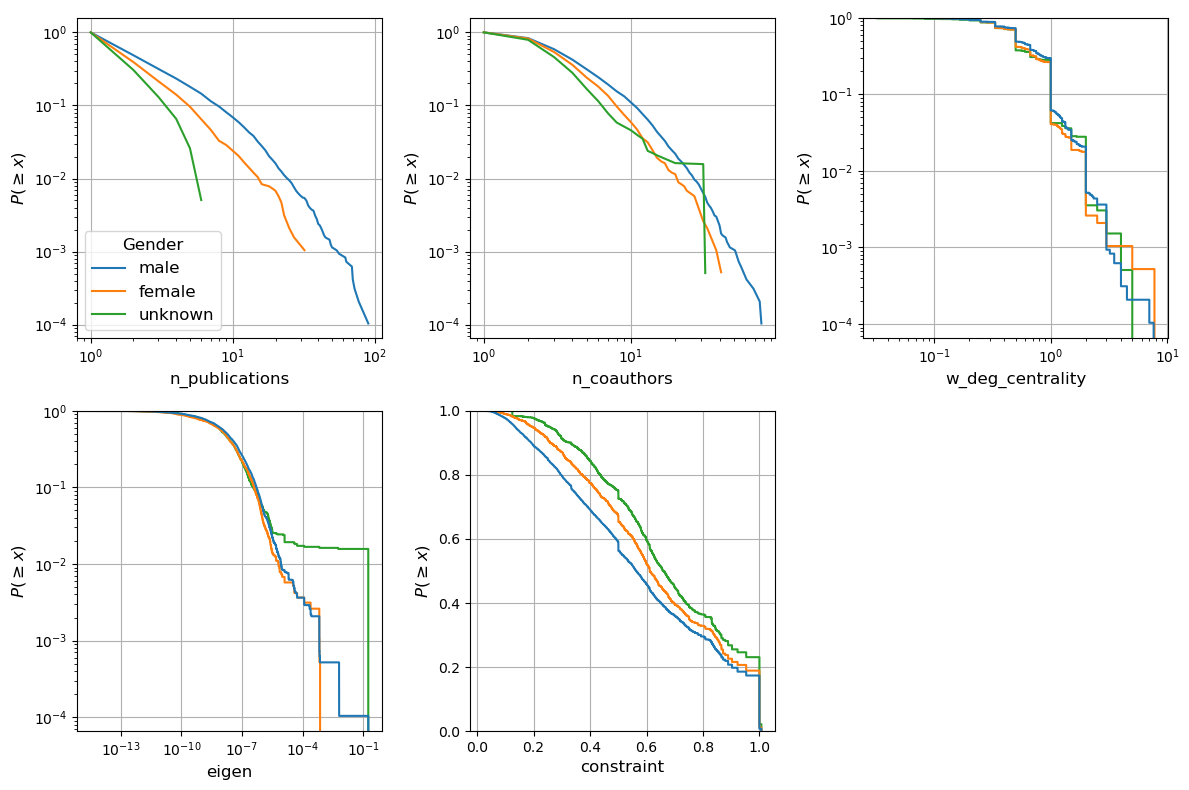

In [12]:
# plot the complementary cumulative distributions of these measures
plt.figure(figsize=(12,8))

for n_plot, measure in enumerate(authors.columns[2:], 1):
    
    plt.subplot(2, 3, n_plot)
    if measure in ['n_publications', 'n_coauthors']:
        for gender in ['male', 'female', 'unknown']:
            powerlaw.plot_ccdf(authors.query(f"gender == '{gender}'")[measure], label=gender)
    else:
        #sns.kdeplot(authors, x=measure, hue='gender', common_norm=False, legend=False, cumulative=True,
        #           complementary=True)
        
        sns.ecdfplot(data=authors, x=measure, hue="gender", complementary=True, legend=False)

    
    plt.xlabel(measure, fontsize=12)
    plt.ylabel(r"$P\left( \geq x \right)$", fontsize=12)
    
    if measure in ['eigen', 'page_rank', 'w_deg_centrality']:
        plt.xscale('log')
        #plt.yscale('log' if measure != 'w_deg_centrality' else 'linear')
        plt.yscale('log')
    if n_plot == 1:
        plt.legend(title="Gender", fontsize=12, title_fontsize=12)
        
    plt.grid()
    
plt.tight_layout()

From the distribution of the number of publications, we can already see that it is an unfair measure for the performance of authors since the distribution for male and female authors are different, expecially in terms of the maximum number of publications. In addition, the distribution of the number of coauthors (i.e., degree) and the constraint index are different between genders. Male authors tend to have more collaborators and can act as brokers in the coauthorship network (lower constraint) as compared to female authors.

In the following, I will explore whether these differences between male and female authors are statistically significant through an ANOVA test.

In [13]:
# test if average are different for each of them
# ANOVA + post-hoc test (Turkey test, if anova rejects null hypothesis)
metrics = ['n_coauthors', 'w_deg_centrality', 'eigen', 'constraint']
genders = ['male', 'female', 'unknown']

for metric in metrics:
    
    print(f"Centrality measure: {metric}")
    anova = stats.f_oneway(*(authors.query(f"gender == '{gender}'")[metric] for gender in genders))
    p_ = f"p = {round(anova.pvalue, 4)}" if anova.pvalue >= 0.0001 else "p < 0.0001"
    print(f"Results ANOVA: {round(anova.statistic, 2)} ({p_})")
    if anova.pvalue < 0.05:
        # perform Turkey test
        t_test = pairwise_tukeyhsd(authors[metric], authors.gender)
        t_test_summ = t_test.summary()
        t_test_summ = pd.DataFrame(t_test_summ.data[1:], columns=t_test_summ.data[0])
        t_test_summ = t_test_summ[t_test_summ.reject == True]
        print("Difference in mean significant for:")
        for _, row in t_test_summ.iterrows():
            p_ = f"p = {round(row['p-adj'], 4)}" if row['p-adj'] >= 0.0001 else "p < 0.0001"
            print(f"{row.group2} - {row.group1}: {row.meandiff} (95% CI: {row.lower} - {row.upper}; {p_})")
    
    print()

Centrality measure: n_coauthors
Results ANOVA: 65.65 (p < 0.0001)
Difference in mean significant for:
male - female: 0.8427 (95% CI: 0.5596 - 1.1258; p < 0.0001)
unknown - female: -0.3669 (95% CI: -0.73 - -0.0037; p = 0.047)
unknown - male: -1.2095 (95% CI: -1.4894 - -0.9297; p < 0.0001)

Centrality measure: w_deg_centrality
Results ANOVA: 14.63 (p < 0.0001)
Difference in mean significant for:
male - female: 0.0408 (95% CI: 0.0173 - 0.0643; p = 0.0001)
unknown - male: -0.0416 (95% CI: -0.0648 - -0.0184; p = 0.0001)

Centrality measure: eigen
Results ANOVA: 88.33 (p < 0.0001)
Difference in mean significant for:
unknown - female: 0.0028 (95% CI: 0.0021 - 0.0034; p < 0.0001)
unknown - male: 0.0028 (95% CI: 0.0023 - 0.0033; p < 0.0001)

Centrality measure: constraint
Results ANOVA: 98.73 (p < 0.0001)
Difference in mean significant for:
male - female: -0.0479 (95% CI: -0.0643 - -0.0314; p < 0.0001)
unknown - female: 0.0439 (95% CI: 0.0229 - 0.065; p < 0.0001)
unknown - male: 0.0918 (95% CI:

The only difference between male and females not statistically significant is in the eigenvector centrality. This result is not trivial given the difference in degree, thus it should be further inspected.

In [14]:
# run regression: n_publications ~ centrality measures
# Generalized Linear Model, Poisson and Negative Binomial
poiss_model = sm.GLM(authors['n_publications'], 
                     authors[['n_coauthors', 'w_deg_centrality', 'eigen', 'constraint']], 
                             family=sm.families.Poisson())
poiss_results = poiss_model.fit()

nb_model = sm.GLM(authors['n_publications'], 
                     authors[['n_coauthors', 'w_deg_centrality', 'eigen', 'constraint']],
                     family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()

In [15]:
print(poiss_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         n_publications   No. Observations:                13520
Model:                            GLM   Df Residuals:                    13516
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25749.
Date:                Sun, 18 Dec 2022   Deviance:                       17152.
Time:                        18:17:52   Pearson chi2:                 2.32e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.8566
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
n_coauthors          0.0750      0.000  

In [16]:
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         n_publications   No. Observations:                13520
Model:                            GLM   Df Residuals:                    13516
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25876.
Date:                Sun, 18 Dec 2022   Deviance:                       1275.7
Time:                        18:17:52   Pearson chi2:                 1.68e+03
No. Iterations:                    13   Pseudo R-squ. (CS):             0.4324
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
n_coauthors          0.1015      0.002  

Results of both regressions are consistent: all the metrics are associated to the number of publications of authors. These are also statistically significant. As expected, the coefficients of number of coauthors and degree centrality are positive, while the constraint index has a negative coefficient. Again, the negative coefficient related to the eigenvector centrality is counter intuitive and would deserve further inspection.

### Q3: Is the network assortative with respect to authors’ gender?

It is worth asking to what extent male and female authors collaborate between each other. The Newman's attribute assortatitivity can be used. Across time.

Following [3], in which authors show an increase in assortativity across time, two other measures are used in order to disentangle the relative effect of men and women in the observed assortativity.

The measures are:
$$ H_m = \frac{E_{m,m}}{E_{m,m} + E_{f,m}} $$
$$ H_f = \frac{E_{f,f}}{E_{f,f} + E_{f,m}} $$
where $E_{x,y}$ is the number of edges between gender $x$ and $y$.

Both assortativity and fraction of male-male and female-female links are compared against a null model in which pairs of edges are swapped randomly.

Note: I have made two modifications that returns slightly different results than the ones shown during the presentation. First, I have removed all publications coauthored by more than 20 authors (this caused the peak of the z-score of $H_f$). Second, I have doubled the number of random swaps. This was done because the assortativity of the null model increased in time as well when fewer number of swaps were performed.

In [17]:
def proportion_links_gender(G):
    
    assort_matrix = nx.attribute_mixing_matrix(G, attribute='gender', 
                                               mapping={'male':0, 'female':1, 'unknown':2})
    
    Hm = assort_matrix[0,0] / assort_matrix[0].sum() if assort_matrix[0].sum() > 0 else 0
    Hf = assort_matrix[1,1] / assort_matrix[1].sum() if assort_matrix[1].sum() > 0 else 0
    
    return Hm, Hf


def z_score(val, vals_null):
    return (val - np.mean(vals_null)) / np.std(vals_null) if np.std(vals_null) > 0 else 0

In [18]:
N_ITERS = 100

homophily_df = []
#pbar = tqdm(total=publications.year.nunique())
#for year, rows in publications.groupby(pd.Grouper('year', sort=True)):
y_bins = np.arange(1950, 2020, step=5)
pbar = tqdm(total=y_bins.shape[0]-1)
for year_l, year_u in zip(y_bins[:-1], y_bins[1:]):
    
    rows = publications[(publications.year>=year_l)&(publications.year<year_u)]
    if rows.shape[0] < 50:
        # if few publication, continue
        pbar.update(1)
        continue
        
    year = year_l
                
    # build the network from the publication of this year and project to users
    # remove paper '5002260', authored by ~30 authors with unknown gender.
    # It causes a huge peak in z-score in 1985 (as the one in slide 12 of the presentation)
    # I remove all papers authored by more than 20 authors
    edges_year = edges[edges.publication_id.isin(rows.publication_id)]
    n_authors_per_paper = edges.groupby('publication_id').size()
    edges_year = edges_year[edges_year.publication_id.isin(n_authors_per_paper[n_authors_per_paper < 20].index)]
    G_year = nx.from_pandas_edgelist(edges_year, 
                                     source='author_id', target='publication_id')
    G_year_users = nx.bipartite.project(G_year, nodes=edges_year.author_id.unique())
    
    nx.set_node_attributes(G_year_users, 
                           authors[authors.author_id.isin(edges_year.author_id.unique())]\
                                                   .set_index('author_id').to_dict()['gender'], 
                           name='gender')

    assort_all = nx.attribute_assortativity_coefficient(G_year_users, attribute='gender')
    authors_gendered_set = set(edges_year.author_id)\
                                .intersection(authors.query("gender != 'unknown'").author_id)
    assort_gendered = nx.attribute_assortativity_coefficient(G_year_users, attribute='gender', 
                                       nodes=authors_gendered_set)
    Hm, Hf = proportion_links_gender(G_year_users)
    
    # null model
    assort_gendered_rand = []
    Hms_rand, Hfs_rand = [], []
    for _ in range(N_ITERS):
        G_sw = nx.Graph(G_year_users)
        nx.double_edge_swap(G_sw, nswap=G_sw.number_of_edges()*2, max_tries=G_sw.number_of_edges()*10, seed=RNG)
        assort_gendered_ = nx.attribute_assortativity_coefficient(G_sw, attribute='gender', 
                                       nodes=authors_gendered_set)
        Hm_r, Hf_r = proportion_links_gender(G_sw)
        assort_gendered_rand.append(assort_gendered_)
        Hms_rand.append(Hm_r)
        Hfs_rand.append(Hf_r)
        
    z_Hm = z_score(Hm, Hms_rand)
    z_Hf = z_score(Hf, Hfs_rand)
    ass_r, ass_r_l, ass_r_u = mean_confidence_interval(assort_gendered_rand, confidence=0.95)
    homophily_df.append([year, assort_all, assort_gendered, ass_r, ass_r_l, ass_r_u, z_Hm, z_Hf])
    pbar.update(1)
    
homophily_df = pd.DataFrame(homophily_df, columns=['year', 'assort', 'assort_gendered',
                                                  'assort_null', 'assort_null_l', 'assort_null_u',
                                                  'z_Hm', 'z_Hf'])

  0%|          | 0/13 [00:00<?, ?it/s]

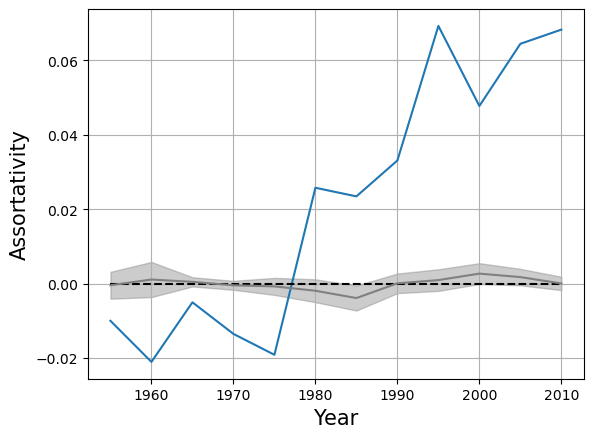

In [19]:
#sns.lineplot(homophily_df, x='year', y='assort')
sns.lineplot(homophily_df, x='year', y='assort_gendered')
plt.hlines(0, homophily_df.year.min(), homophily_df.year.max(), color='k', linestyle='dashed')

plt.fill_between(homophily_df.year, homophily_df.assort_null_l, homophily_df.assort_null_u, color='grey', alpha=0.4)
plt.plot(homophily_df.year, homophily_df.assort_null, color='grey')

plt.ylabel("Assortativity", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.grid()


Text(0.5, 0, 'Year')

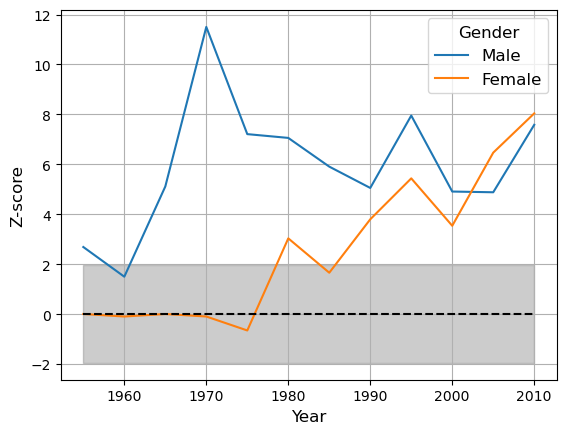

In [20]:
sns.lineplot(homophily_df, x='year', y='z_Hm', label='Male')
sns.lineplot(homophily_df, x='year', y='z_Hf', label='Female')

# this is significativity level of z-score
plt.fill_between(homophily_df.year, -1.96, 1.96, color='grey', alpha=0.4)
plt.hlines(0, homophily_df.year.min(), homophily_df.year.max(), color='k', linestyle='dashed')
plt.grid()
plt.legend(title='Gender', fontsize=12, title_fontsize=12)

plt.ylabel("Z-score", fontsize=12)
plt.xlabel("Year", fontsize=12)

Gender assortativity starts to increase starting from the early 80s, reaching values close to 0.07 that is far from what predicted by the null model. This corresponds to the increase of female-female edges as can be seen from the z-score. This increase in assortativity and same-gender links across time is consistent with the results of [3].

### Conclusions

In this project, I have explored the structural properties of a coauthorship network focusing on questions involving both homogeneity (**Q1** and **Q3**) and performance (**Q1**) outcome of network nodes, representing authors. 

I have showed that the Granovetter's hypothesis of the Strenght of Weak ties is not supported by this dataset, where weak ties occur in strongly connected neighborhoods and strong ties connect different neighborhoods. Accordingly to [4], weak ties in strongly connected neighborhoods are likely due to the involvement of junior researcher within teams, while strong ties connect senior researchers belonging to different groups. This feature makes coauthorship networks different from other social networks. 

Then, network centrality measures show differences between male and female authors. Male authors tend to have more collaborators and lower constraint index, associated to higher possibilities to act as brokers. Negative binomial regression, in which the number of publications is the dependent variable, shows these measures to have coefficents that are significantly different from zero. Unexpectedly, the coefficient of the eigenvector centrality is negative. These results suggest that node centrality measures are related to authors' performance and that, as suggested by [3], female authors struggle in occupying these positions in the collaboration network.

Finally, gender assortativity in the collaboration network increases starting from 1980s, both driven by male and female authors. 

Despite the small scale and the specific focus around the papers published under the Informs group compared to other works, this dataset shows some caracteristics that are similar to other collaboration datasets. 